In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [454]:
train_data = pd.read_csv('dataset/train.csv')
train_data['date_time'] = pd.to_datetime(train_data['date_time'])
train_data.head()

,date_time,is_holiday,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,air_pollution_index,traffic_volume
0,2012-10-02 09:00:00,None,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,121,5545
1,2012-10-02 10:00:00,None,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,178,4516
2,2012-10-02 11:00:00,None,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,113,4767
3,2012-10-02 12:00:00,None,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,20,5026
4,2012-10-02 13:00:00,None,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,281,4918


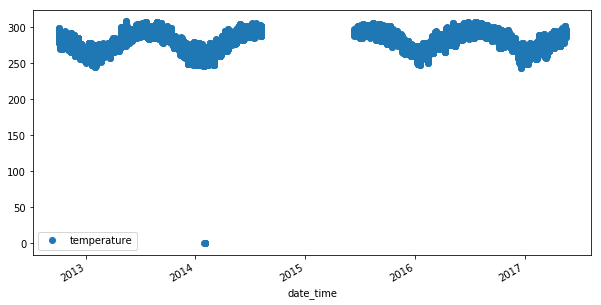

In [513]:
# Visual inspection(Date ranges are not continuous)
train_data.plot(x='date_time',y='temperature',figsize=(10,5),style="o")

In [6]:
train_data['is_holiday'].value_counts()

None                         33707
Christmas Day                    5
New Years Day                    5
Thanksgiving Day                 5
Veterans Day                     4
Labor Day                        4
Washingtons Birthday             4
Columbus Day                     4
Martin Luther King Jr Day        3
Independence Day                 3
State Fair                       3
Memorial Day                     3
Name: is_holiday, dtype: int64

In [7]:
train_data['weather_type'].value_counts()

Clouds          11213
Clear            9233
Mist             4047
Rain             3940
Snow             2070
Drizzle          1204
Haze              902
Fog               567
Thunderstorm      553
Smoke              17
Squall              4
Name: weather_type, dtype: int64

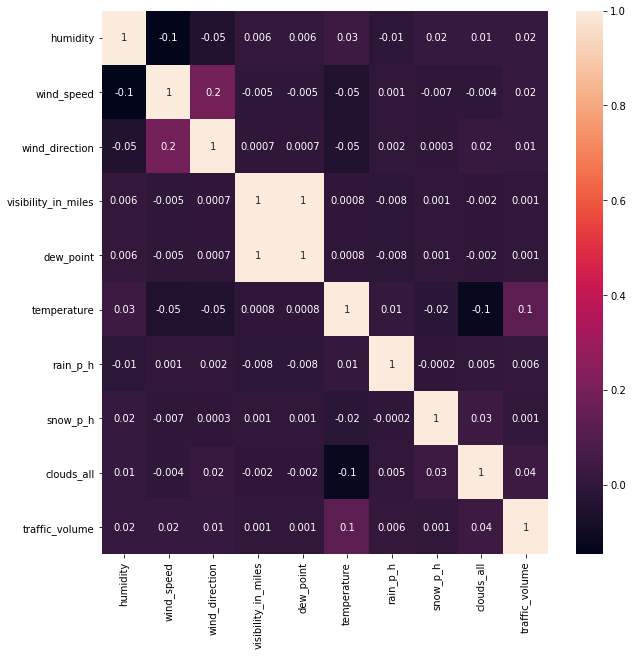

In [8]:
# Check for correlations (Doesn't seem to have any)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train_data.corr(), annot = True, fmt='.1g', ax=ax)

In [9]:
# Check for missing values (None present)
print(train_data.isnull().values.sum())

0


### Procedure

#### Steps:
   
    1. Remove outliers from the numerical columns's data - temperature, rain fall, snow fall.
    2. Separate out categorical columns, date columns and keep in separate df. Separate out the labels columns at this step, 
    no need to normalize labels.
    3. Standardize(Not normalise here) all numerical columns data by subtracting by mean and dividing by variance.
    4. Join back the dropped categorical columns.
    5. Need to one-hot encode/ Label encoding all categorical data.
    *** Do not touch the given Test data ever. We will split training data and test on that. 
     
    6. Make k-fold cross-validation/ train-test split preparation.
    7. Use a Random Forest and fit the data.
    8. Simultaneously train and test on the test data. Plot the graph at every 50 epochs. Stop the training 
    where both losses meet.
    9. Prepare the prediction of Test data. (Do all preprocessing first)

#### Steps:
   
    1. Remove outliers from the numerical columns's data - temperature, rain fall, snow fall.
    2. Separate out categorical columns, date columns and keep in separate df. Separate out the labels columns at this step, 
    no need to normalize labels.
    3. Standardize(Not normalise here) all numerical columns data by subtracting by mean and dividing by variance.
    4. Join back the dropped categorical columns.
    5. Need to one-hot encode/ Label encoding all categorical data.
    *** Do not touch the given Test data ever. We will split training data and test on that. 
     
    6. Make k-fold cross-validation/ train-test split preparation.
    7. Use a Random Forest and fit the data.
    8. Simultaneously train and test on the test data. Plot the graph at every 50 epochs. Stop the training 
    where both losses meet.
    9. Prepare the prediction of Test data. (Do all preprocessing first)

#### Step: 1 : Outliers removal

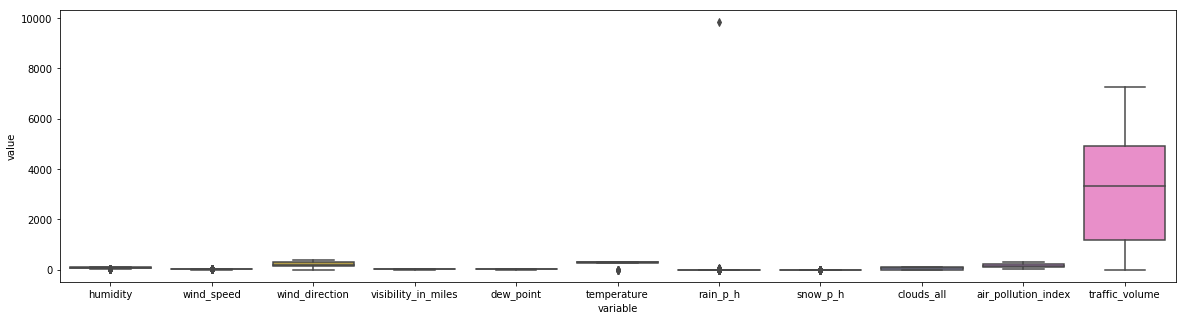

In [371]:
train_df = train_data.copy()

df = train_df.drop(['date_time','is_holiday','weather_type'],axis=1)
plt.figure(figsize=(20,5))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.show()

In [372]:
df.describe()

,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,air_pollution_index,traffic_volume
count,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000
mean,71.209007,3.378193,199.471852,4.989748,4.989748,280.069587,0.448739,0.000318,50.458785,154.841422,3240.118163
std,16.852248,2.055792,99.841088,2.570021,2.570021,13.415256,53.526500,0.009760,38.871734,83.735515,1991.487289
min,13.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000
25%,60.000000,2.000000,130.000000,3.000000,3.000000,271.720000,0.000000,0.000000,1.000000,83.000000,1165.250000
50%,72.000000,3.000000,200.000000,5.000000,5.000000,280.150000,0.000000,0.000000,64.000000,155.000000,3335.000000
75%,85.000000,5.000000,290.000000,7.000000,7.000000,290.620000,0.000000,0.000000,90.000000,228.000000,4926.000000
max,100.000000,16.000000,360.000000,9.000000,9.000000,308.240000,9831.300000,0.510000,100.000000,299.000000,7280.000000


In [373]:
# Data specific outlier removal
# Dropping rain_p_h outlier
rain_outlier = train_df[train_df['rain_p_h']==float(train_df['rain_p_h'].max())].index
train_df.drop(rain_outlier, inplace=True)

# Dropping temperature outliers
temp_outlier = train_df[train_df['temperature']==float(train_df['temperature'].min())].index
train_df.drop(temp_outlier, inplace=True)

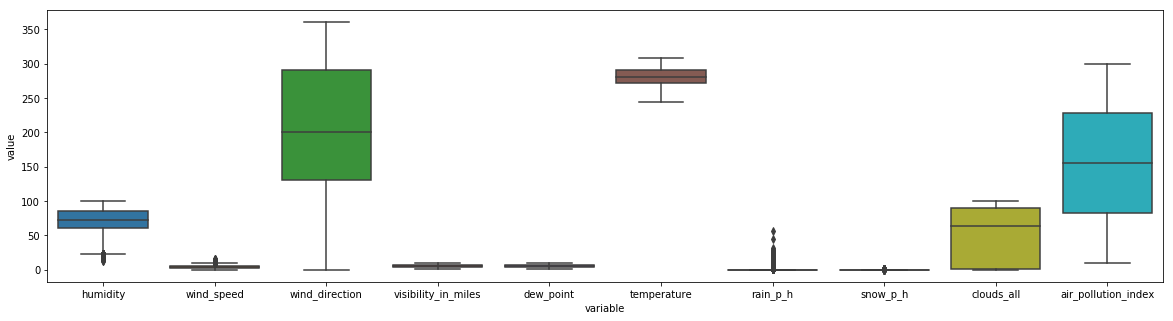

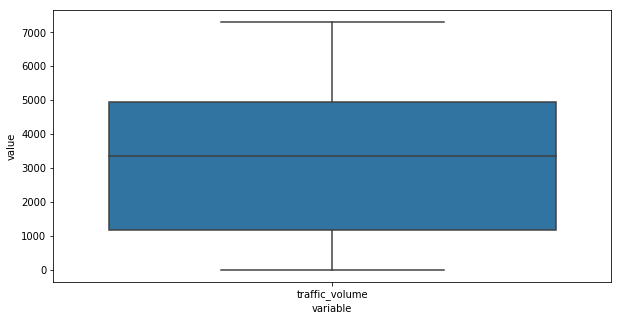

In [376]:
df = train_df.drop(['date_time','is_holiday','weather_type','traffic_volume'],axis=1)
plt.figure(figsize=(20,5))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.show()
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(train_df[['traffic_volume']]))
plt.show()

#### Step:2 : Separate out categorical columns, date time and labels

In [411]:
from sklearn import preprocessing
train_df2 = train_df.copy()
dropped_df = train_df2[['date_time','is_holiday','weather_type']]
labels = train_df2[['air_pollution_index']]

# Removing categorical and index data
df = train_df2.drop(['date_time','is_holiday','weather_type','air_pollution_index'],axis=1)

#### Step:3 : Standardization (Normalisation)

In [412]:
# normalized_data = preprocessing.normalize(df[['traffic_volume']])
# Get column names first
names = df.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit data on the scaler object
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=names)
scaled_df.head()

,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,traffic_volume
0,1.055772,-0.670689,1.297487,-1.552967,-1.552967,0.649201,-0.135926,-0.032551,-0.269454,1.157217
1,-0.249665,-0.184235,1.307504,-1.552967,-1.552967,0.735463,-0.135926,-0.032551,0.631040,0.640472
2,-0.309003,-0.184235,1.297487,-1.163805,-1.163805,0.753035,-0.135926,-0.032551,1.016966,0.766520
3,-0.309003,-0.184235,1.297487,0.003679,0.003679,0.796964,-0.135926,-0.032551,1.016966,0.896585
4,-0.368341,-0.184235,1.297487,0.782003,0.782003,0.877634,-0.135926,-0.032551,0.631040,0.842349


In [413]:
scaled_df.describe()

,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,traffic_volume
count,3.373900e+04,3.373900e+04,3.373900e+04,3.373900e+04,3.373900e+04,3.373900e+04,3.373900e+04,3.373900e+04,3.373900e+04,3.373900e+04
mean,-3.790204e-16,1.147861e-15,1.759002e-15,-2.397482e-16,-2.397482e-16,-2.112780e-15,9.710626e-16,-4.992331e-15,2.616690e-15,4.967523e-17
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,-3.453920e+00,-1.643598e+00,-1.998314e+00,-1.552967e+00,-1.552967e+00,-2.936238e+00,-1.359257e-01,-3.255110e-02,-1.298590e+00,-1.627379e+00
25%,-6.650314e-01,-6.706895e-01,-6.960218e-01,-7.746437e-01,-7.746437e-01,-6.734735e-01,-1.359257e-01,-3.255110e-02,-1.272861e+00,-1.041835e+00
50%,4.702513e-02,-1.842352e-01,5.212351e-03,3.679497e-03,3.679497e-03,-1.553377e-04,-1.359257e-01,-3.255110e-02,3.480277e-01,4.789817e-02
75%,8.184197e-01,7.886733e-01,9.067992e-01,7.820027e-01,7.820027e-01,8.361010e-01,-1.359257e-01,-3.255110e-02,1.016966e+00,8.463666e-01
max,1.708490e+00,6.139670e+00,1.608033e+00,1.560326e+00,1.560326e+00,2.243440e+00,4.787608e+01,5.221588e+01,1.274250e+00,2.028502e+00


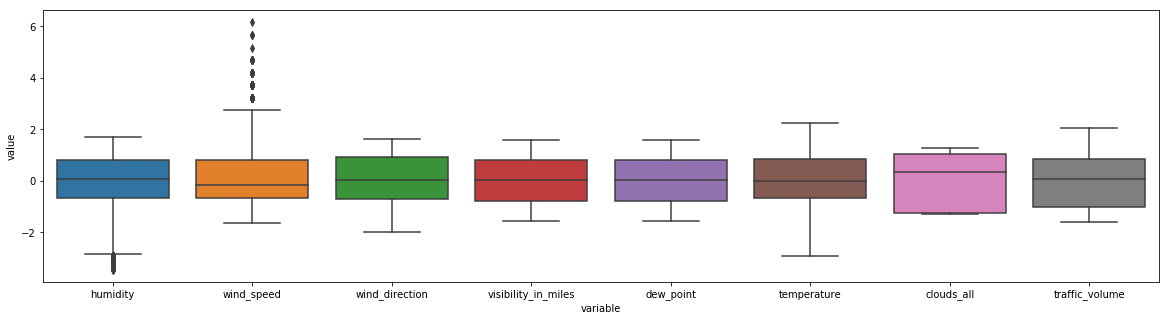

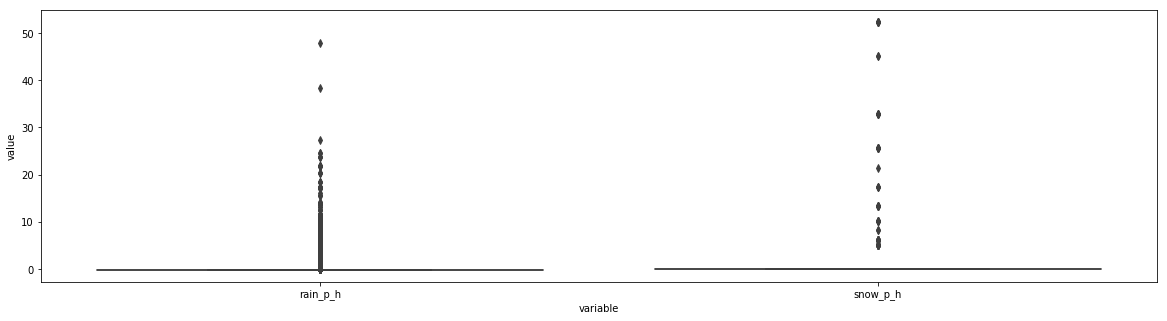

In [414]:
df_test = scaled_df.drop(['rain_p_h','snow_p_h'],axis=1)
plt.figure(figsize=(20,5))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_test))
plt.show()

plt.figure(figsize=(20,5))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(scaled_df[['rain_p_h','snow_p_h']]))
plt.show()

#### Step:4 : Joining back the categorical data

In [520]:
scaled_df2 = scaled_df.join(dropped_df)
scaled_df2 = scaled_df2.set_index('date_time')
scaled_df2.head()

,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,traffic_volume,is_holiday,weather_type
date_time,,,,,,,,,,,,
2017-05-18 00:00:00,1.055772,-0.670689,1.297487,-1.552967,-1.552967,0.649201,-0.135926,-0.032551,-0.269454,1.157217,None,Rain
2017-05-18 00:00:00,-0.249665,-0.184235,1.307504,-1.552967,-1.552967,0.735463,-0.135926,-0.032551,0.631040,0.640472,None,Mist
2017-05-18 00:00:00,-0.309003,-0.184235,1.297487,-1.163805,-1.163805,0.753035,-0.135926,-0.032551,1.016966,0.766520,None,Drizzle
2017-05-18 01:00:00,-0.309003,-0.184235,1.297487,0.003679,0.003679,0.796964,-0.135926,-0.032551,1.016966,0.896585,None,Rain
2017-05-18 01:00:00,-0.368341,-0.184235,1.297487,0.782003,0.782003,0.877634,-0.135926,-0.032551,0.631040,0.842349,None,Mist


#### Step: 5 : One-hot Encoding

In [521]:
# One-hot encoding categorical data in train and test dataset
train_data_copy = scaled_df2.copy()
train_data_copy = pd.get_dummies(train_data_copy, columns=['is_holiday'],prefix=['holiday'])
train_data_copy = pd.get_dummies(train_data_copy, columns=['weather_type'],prefix=['weather'])
train_data_copy.head()

,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,traffic_volume,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,holiday_New Years Day,holiday_None,holiday_State Fair,holiday_Thanksgiving Day,holiday_Veterans Day,holiday_Washingtons Birthday,weather_Clear,weather_Clouds,weather_Drizzle,weather_Fog,weather_Haze,weather_Mist,weather_Rain,weather_Smoke,weather_Snow,weather_Thunderstorm
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-18 00:00:00,1.055772,-0.670689,1.297487,-1.552967,-1.552967,0.649201,-0.135926,-0.032551,-0.269454,1.157217,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2017-05-18 00:00:00,-0.249665,-0.184235,1.307504,-1.552967,-1.552967,0.735463,-0.135926,-0.032551,0.631040,0.640472,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2017-05-18 00:00:00,-0.309003,-0.184235,1.297487,-1.163805,-1.163805,0.753035,-0.135926,-0.032551,1.016966,0.766520,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2017-05-18 01:00:00,-0.309003,-0.184235,1.297487,0.003679,0.003679,0.796964,-0.135926,-0.032551,1.016966,0.896585,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2017-05-18 01:00:00,-0.368341,-0.184235,1.297487,0.782003,0.782003,0.877634,-0.135926,-0.032551,0.631040,0.842349,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### Step:6 : Cross-validation/Train-test split

In [522]:
X = train_data_copy
y = labels

#### Step:7 :Random Forest Classifier

In [523]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

In [524]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kf = KFold(n_splits=20)
for train_idx, test_idx in kf.split(X):
#     print("%s %s" % (train_idx, test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train.values.ravel())
    pred = clf.predict(X_test)
    score = max(0, (100-mean_absolute_error(y_test, pred)))
    print("Score:", score)

Score: 8.26318909306461
Score: 4.615293420272678
Score: 2.300533491404863
Score: 0
Score: 6.080616478956728
Score: 0
Score: 0
Score: 3.7107291049199773
Score: 1.6342620035566142
Score: 0
Score: 1.1766449318316603
Score: 6.576170717249553
Score: 4.4546532305868425
Score: 0.7729697688203885
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0
Score: 0


#### Step:9 : Make prediction on Test Data

In [461]:
test_data = pd.read_csv('dataset/test.csv')
test_data['date_time'] = pd.to_datetime(test_data['date_time'])
dropped_df = test_data[['date_time','is_holiday','weather_type']]

# Removing categorical and index data
df_test = test_data.drop(['date_time','is_holiday','weather_type'],axis=1)

In [466]:
# Standardization
names = df_test.columns
scaled_df_test = scaler.fit_transform(df_test)
scaled_df_test = pd.DataFrame(scaled_df_test, columns=names)

# Joining back dropped cols
scaled_df2_test = scaled_df_test.join(dropped_df)
scaled_df2_test = scaled_df2_test.set_index('date_time')

# One hot encoding
test_data_copy = scaled_df2_test.copy()
test_data_copy = pd.get_dummies(test_data_copy, columns=['is_holiday'],prefix=['holiday'])
test_data_copy = pd.get_dummies(test_data_copy, columns=['weather_type'],prefix=['weather'])
test_data_copy.head(3)

,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,traffic_volume,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,holiday_New Years Day,holiday_None,holiday_State Fair,holiday_Thanksgiving Day,holiday_Veterans Day,holiday_Washingtons Birthday,weather_Clear,weather_Clouds,weather_Drizzle,weather_Fog,weather_Haze,weather_Mist,weather_Rain,weather_Smoke,weather_Snow,weather_Thunderstorm
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-18,-0.228588,-1.178656,-1.918931,-0.388810,-0.388810,0.101099,-0.143444,0.0,1.10113,-1.346572,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2017-05-18,-0.228588,-1.178656,-1.918931,-0.388810,-0.388810,0.101099,-0.143444,0.0,1.10113,-1.346572,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2017-05-18,-0.559609,-1.178656,-2.203162,-1.548819,-1.548819,0.101099,-0.143444,0.0,1.10113,-1.346572,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [480]:
# Add bias column for missing weather category
test_data_copy['bias'] = np.zeros(test_data_copy.shape[0])

In [507]:
X_actual_test = test_data_copy
predictions = clf.predict(X_actual_test)

In [508]:
submission = pd.DataFrame(predictions, columns=['air_pollution_index'])
submission['date_time'] = X_actual_test.index
submission = submission.set_index('date_time')
submission.head()

,air_pollution_index
date_time,
2017-05-18 00:00:00,296
2017-05-18 00:00:00,224
2017-05-18 00:00:00,141
2017-05-18 01:00:00,51
2017-05-18 01:00:00,156


In [510]:
submission.to_csv('predictions.csv')